In [1]:
import numpy as np 
import cv2
from skimage import filters
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_otsu
import os 
import random 
from sklearn.metrics import jaccard_score, f1_score

Processing landscape.jpg...


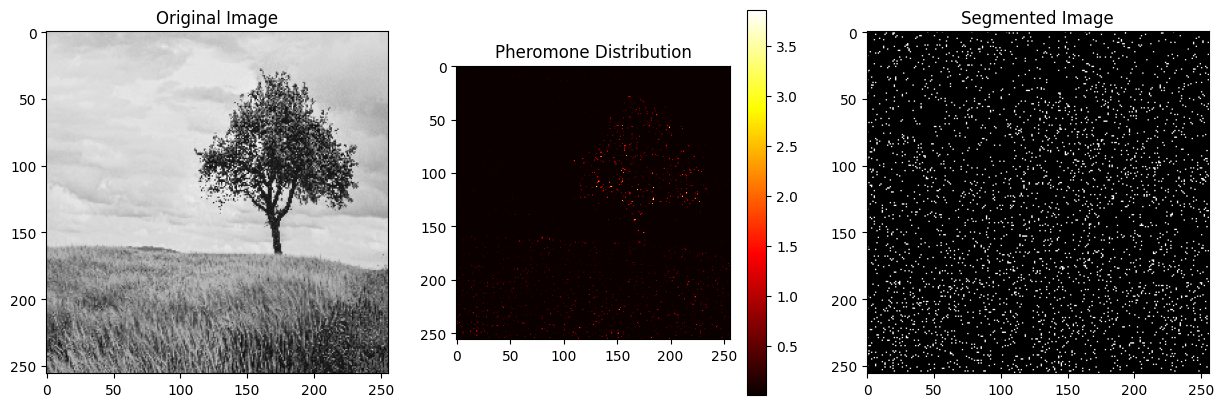

Processing image25.jpg...


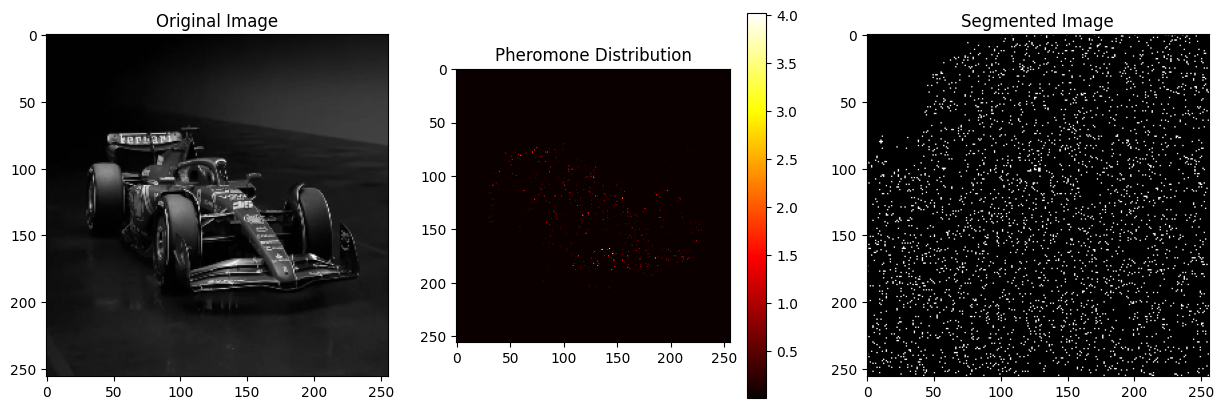

Processing dog.jpg...


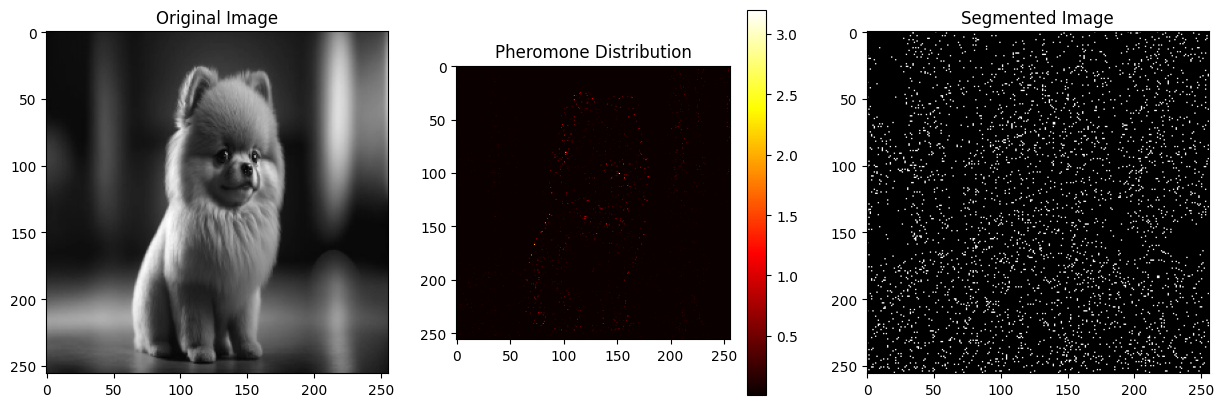

Processing image26.jpg...


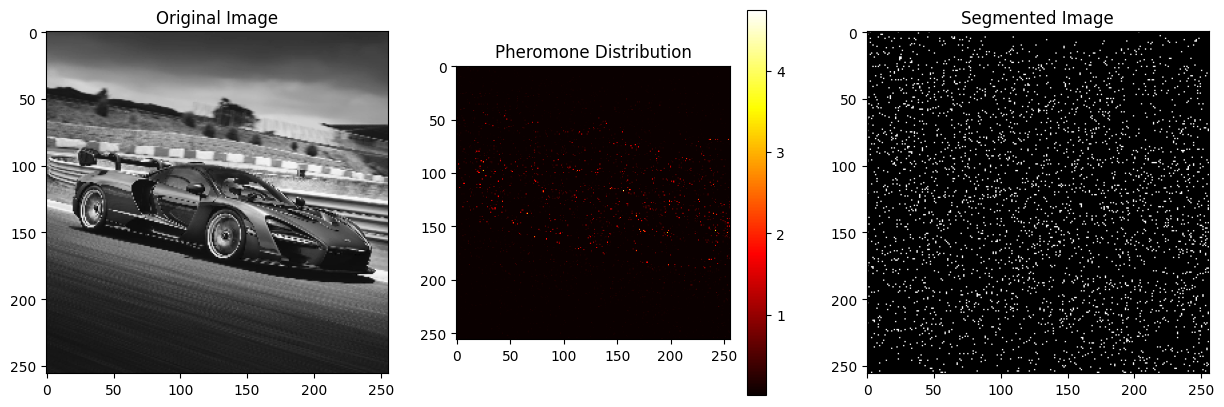

Processing dog1.jpg...


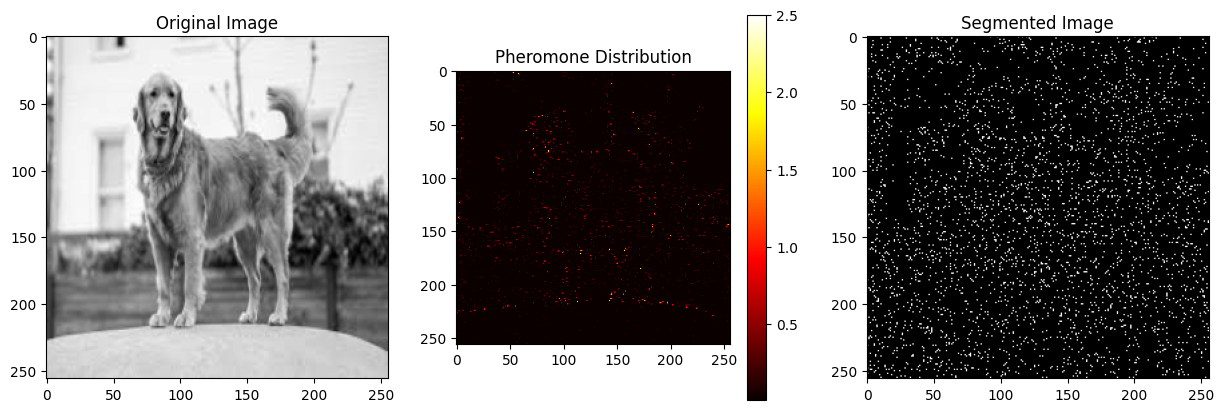

Processing blackandwhitelandscape.jpg...


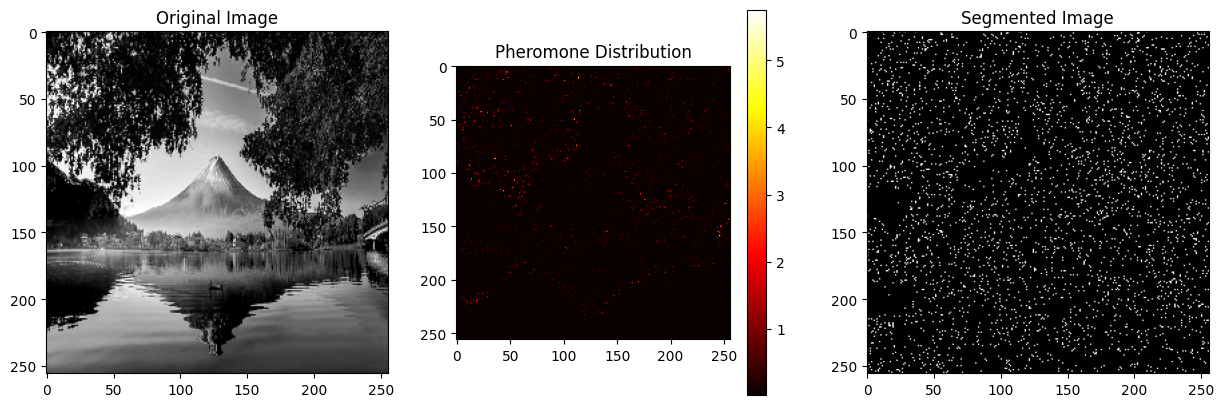

Processing dog2.jpg...


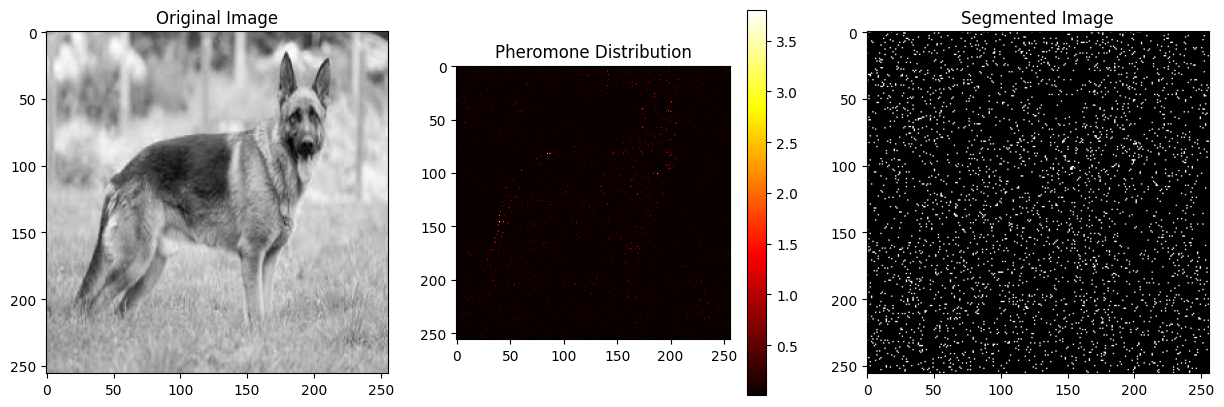

Processing image21.jpg...


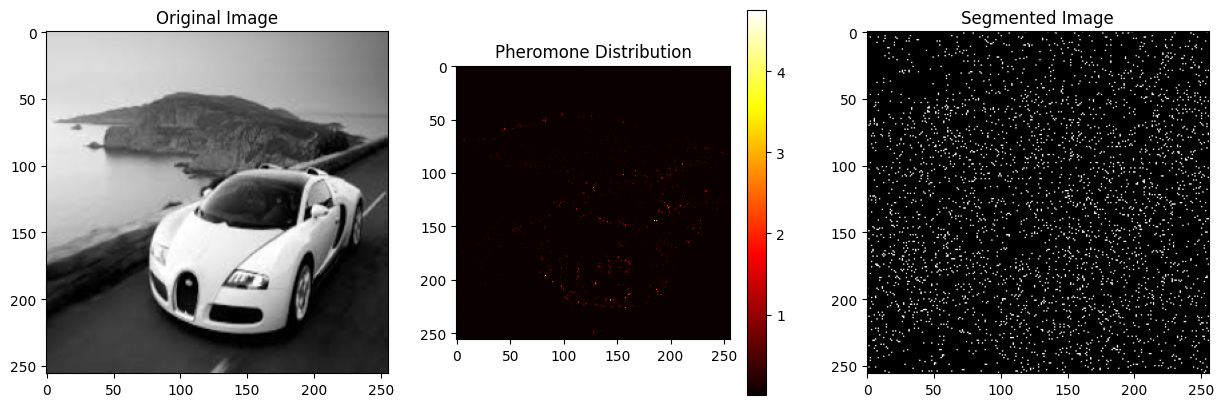

Processing AURORA.jpg...


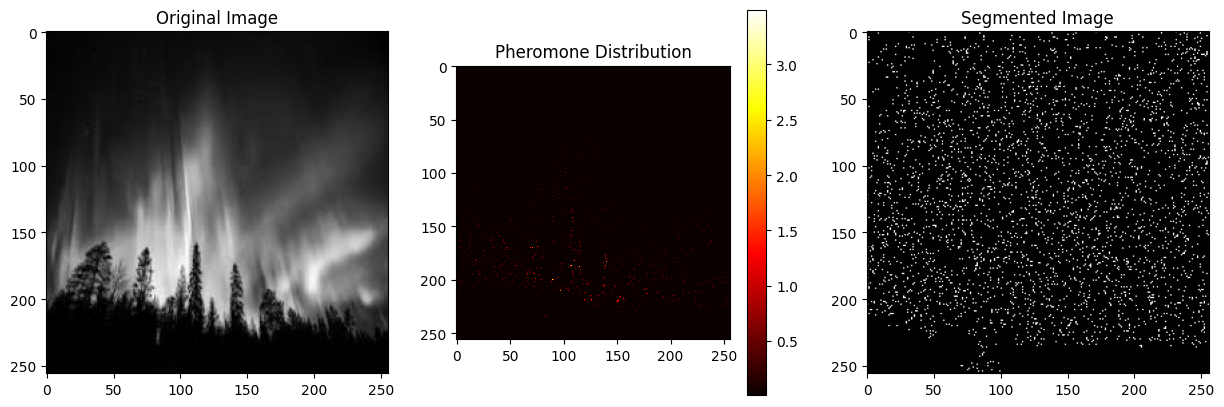

Processing landscape3.jpg...


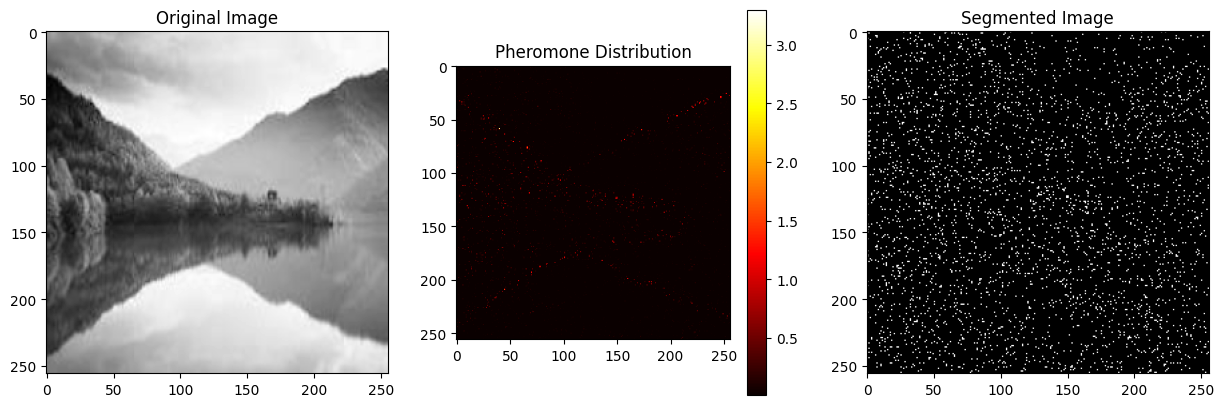

Processing complete. Segmented images saved to: output_images


In [4]:
def pheromone_matrix(image,initial_pheromone=0.1):
    return np.full(image.shape,initial_pheromone)

def compute_transition_probabilities(pheromones,heuristic,alpha=1,beta=1):
    numerator = (pheromones ** alpha) * (heuristic ** beta)
    denominator = np.sum(numerator)
    return numerator / denominator


def evaporate_pheromones(pheromones, evaporation_rate=0.1):
    """Evaporate pheromone levels."""
    return (1 - evaporation_rate) * pheromones


def update_pheromones(pheromones, path, contribution=1):
    """Update pheromone levels based on ant paths."""
    for i, j in path:
        pheromones[i, j] += contribution
    return pheromones

def ant_colony(image,n_ants=200,n_iterations=20,evaporation_rate=0.1):
    #Normalize the image 
    image = image / 255.0


    #initialize pheromones
    pheromones=pheromone_matrix(image)

    # Compute heuristic based on edges
    heuristic = sobel(image)

    # ACO Loop
    for iteration in range(n_iterations):
        for _ in range(n_ants):
            # Randomly select a pixel
            x, y = np.random.randint(0, image.shape[0]), np.random.randint(0, image.shape[1])
            # Update pheromone using heuristic
            pheromones[x, y] += heuristic[x, y] * 10
        # Evaporate pheromones
        pheromones *= (1 - evaporation_rate)

    # Adaptive thresholding
    threshold = np.percentile(pheromones, 95)
    segmented_image = (pheromones >= threshold).astype(np.uint8) * 255

    return segmented_image, pheromones

# Evaluate segmentation
def evaluate_segmentation(predicted, ground_truth):
    """
    Evaluate the segmentation using Dice Similarity Coefficient (DSC) and IoU.
    """
    # Flatten images for metric calculations
    predicted_flat = predicted.flatten()
    ground_truth_flat = ground_truth.flatten()

    # Dice Similarity Coefficient
    intersection = np.sum((predicted_flat == 255) & (ground_truth_flat == 255))
    dice_score = (2 * intersection) / (np.sum(predicted_flat == 255) + np.sum(ground_truth_flat == 255))

    # Intersection over Union (IoU)
    iou_score = jaccard_score(ground_truth_flat, predicted_flat, pos_label=255)

    return dice_score, iou_score



def process_image(input_folder,output_folder,n_random_images=10):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Randomly select a few images
    selected_images = random.sample(image_files, n_random_images)

    dice_scores = []
    iou_scores = []



    for image_file in selected_images:
        print(f"Processing {image_file}...")
        
        image_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, f"segmented_{image_file}")

        # Read and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))  # Resize for consistency

        # Apply ACO-based segmentation
        segmented_image, pheromones = ant_colony(image)

        # Save segmented image
        cv2.imwrite(output_path, segmented_image)

        # Visualize results
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image, cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Pheromone Distribution")
        plt.imshow(pheromones, cmap='hot')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.title("Segmented Image")
        plt.imshow(segmented_image, cmap='gray')
        plt.show()




input_folder = "test_images"  # Replace with your folder path
output_folder = "output_images"  # Replace with desired output folder
n_random_images = 10  # Number of random images to process

process_image(input_folder, output_folder, n_random_images)

print("Processing complete. Segmented images saved to:", output_folder)

In [ ]:
#e